In [44]:
import numpy as np
import math
import pandas as pd

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

from scipy.integrate import solve_ivp

from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from tqdm import tqdm

from copy import deepcopy

import warnings
warnings.filterwarnings("ignore")

In [45]:
def lorenz(t, X, sigma=10, beta=8/3, r=10):
    """The Lorenz equations."""
    x, y, z = X
    xp = sigma*(y - x)
    yp = r*x - y - x*z
    zp = -beta*z + x*y
    return xp, yp, zp 

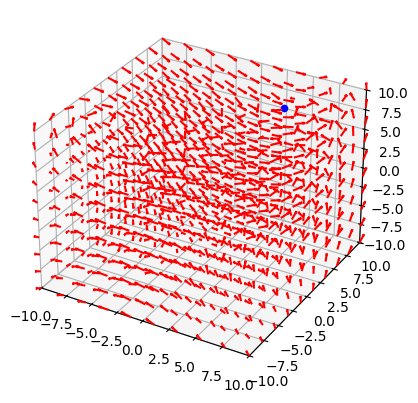

In [46]:
X, Y, Z = np.mgrid[-10:10:10j, -10:10:10j, -10:10:10j]
U, V, W = lorenz(0, [X, Y, Z])

N = np.sqrt(U**2 + V**2 + W**2)
U, V, W = U/N, V/N, W/N

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W, color='r',)
ax.scatter([np.sqrt(24)], [np.sqrt(24)], [9], c='b')

ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_zlim([-10, 10])

plt.show()


In [47]:
def euclidean_distance(point1, point2):
    point1, point2 = np.array(point1), np.array(point2)
    return np.sqrt(np.sum((point1 - point2) ** 2))
lorenz_attractor = (math.sqrt(24), math.sqrt(24), 9)

In [48]:
# Check if the trajectory is attracted to the concerned Lorenz attractor
def is_attracted(x, y, z):
    return euclidean_distance((x, y, z), lorenz_attractor) < 1e-2

In [49]:
## Implement the simulation process and decide if the trajectory is attracted by the Lorenz attractor
def simulation(x0 ,y0 ,z0):
    tmax, n = 1500, 100000
    soln = solve_ivp(lorenz, (0, tmax), (x0, y0, z0), args=(10, 8/3, 10),dense_output=True)
    t = np.linspace(0, tmax, n)
    x, y, z = soln.sol(t)
    return is_attracted(x[n-1], y[n-1], z[n-1])

In [50]:
print(simulation(0, 1, 1.05))

True


In [51]:
def generate_random_points():
    x0 = np.random.uniform(-10, 10)
    y0 = np.random.uniform(-10, 10)
    z0 = np.random.uniform(-10, 10)
    return x0, y0, z0

In [52]:
def generate_dataset(size):
    # Preallocate lists for data
    x0_list, y0_list, z0_list, attracted_list = [], [], [], []
    
    for _ in tqdm(range(size), desc="Generating data"):
        x0, y0, z0 = generate_random_points()
        attracted_result = simulation(x0, y0, z0)
        attracted_result = 1 if attracted_result else -1  # map True to 1 and False to -1
        
        # Append results to lists
        x0_list.append(x0)
        y0_list.append(y0)
        z0_list.append(z0)
        attracted_list.append(attracted_result)
    
    # Create DataFrame from lists
    df = pd.DataFrame({
        'x0': x0_list,
        'y0': y0_list,
        'z0': z0_list,
        'attracted': attracted_list
    })
    
    return df

# Generate the dataset
#df = generate_dataset(50000)

# Save the DataFrame to a CSV file
#df.to_csv('dataset_lorenz_large.csv', index=False)

In [53]:
#df = pd.read_csv('dataset_lorenz_large.csv')

#dataset1 = df.sample(n=15000, random_state=1)
#df_remaining = df.drop(dataset1.index)

#dataset2 = df_remaining.sample(n=15000, random_state=2)
#df_remaining = df_remaining.drop(dataset2.index)

#dataset3 = df_remaining.sample(n=15000, random_state=3)

#dataset1.to_csv("dataset_lorenz_new_training_15000.csv", index=False)
#dataset2.to_csv("dataset_lorenz_new_validation_uniform_15000.csv", index=False)
#dataset3.to_csv("dataset_lorenz_new_testing_uniform_15000.csv", index=False)

In [54]:
def bisection(a, b, delta=0.01):
    distance = np.linalg.norm(np.array([a[0]-b[0], a[1]-b[1], a[2]-b[2]]))
    if distance < delta:
        return (a, b)
    else:
        c = ((a[0]+b[0])/2, (a[1]+b[1])/2, (a[2]+b[2])/2)
        if simulation(c[0], c[1], c[2]):
            return bisection(c, b, delta)
        else:
            return bisection(a, c, delta)

In [55]:
from joblib import Parallel, delayed

#def process_pair(i, df_data_1, df_data_n1):
    #results = []
    #for j in range(len(df_data_n1)):
        #a = (df_data_1.iloc[i]['x0'], df_data_1.iloc[i]['y0'], df_data_1.iloc[i]['z0'])
        #b = (df_data_n1.iloc[j]['x0'], df_data_n1.iloc[j]['y0'], df_data_n1.iloc[j]['z0'])
        #a, b = bisection(a, b) 
        #results.append([a[0], a[1], a[2], 1])
        #results.append([b[0], b[1], b[2], -1])
    #return results

#df_testing = pd.read_csv("dataset_lorenz_new_testing_uniform_15000.csv")
#df_data_1 = df_testing[df_testing['attracted'] == 1].sample(130)
#df_data_n1 = df_testing[df_testing['attracted'] == -1].sample(130)

# Parallel processing with progress tracking
#results = Parallel(n_jobs=-1)(delayed(process_pair)(i, df_data_1, df_data_n1) for i in tqdm(range(len(df_data_1))))
#df_near = [item for sublist in results for item in sublist]  # Flatten the list of lists

#df_near = pd.DataFrame(df_near, columns=['x0', 'y0', 'z0', 'attracted'])
#df_near_validation = df_near.sample(n=15000)
#df_near_testing = df_near.drop(df_near_validation.index).sample(n=15000)
#df_near_validation.to_csv("dataset_lorenz_validation_near_15000.csv", index=False)
#df_near_testing.to_csv("dataset_lorenz_testing_near_15000.csv", index=False)

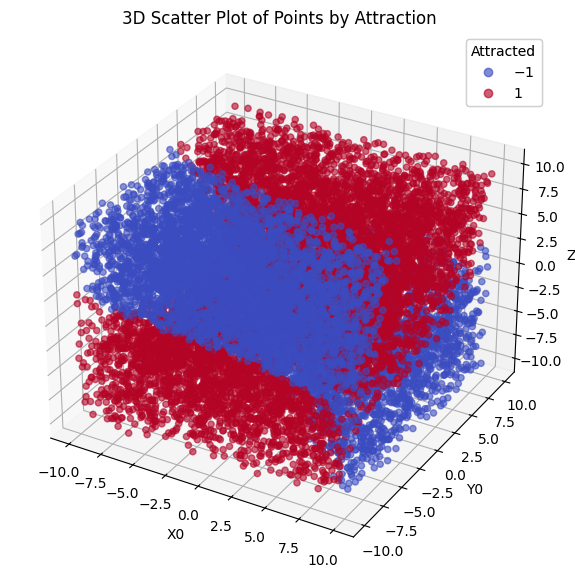

In [56]:
## Plot the training set
df = pd.read_csv('dataset_lorenz_new_training_15000.csv')

# Prepare the figure and 3D axis
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using x0, y0, z0 as coordinates
# Color by 'attracted': map the 'attracted' column to colors
scatter = ax.scatter(df['x0'], df['y0'], df['z0'], c=df['attracted'], cmap='coolwarm', alpha=0.6)

# Legend
legend1 = ax.legend(*scatter.legend_elements(), title="Attracted")
ax.add_artist(legend1)

# Labels
ax.set_xlabel('X0')
ax.set_ylabel('Y0')
ax.set_zlabel('Z0')
ax.set_title('3D Scatter Plot of Points by Attraction')

# Show plot
plt.show()

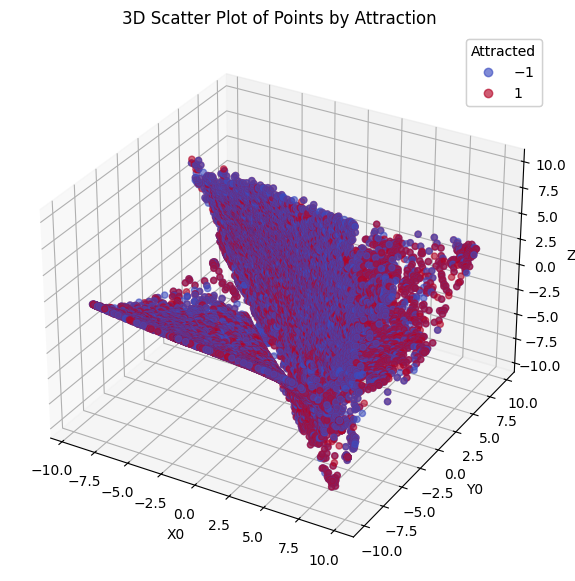

In [57]:
## Plot the near set
df = pd.concat([pd.read_csv('dataset_lorenz_validation_near_15000.csv'), pd.read_csv('dataset_lorenz_testing_near_15000.csv')])


# Prepare the figure and 3D axis
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using x0, y0, z0 as coordinates
# Color by 'attracted': map the 'attracted' column to colors
scatter = ax.scatter(df['x0'], df['y0'], df['z0'], c=df['attracted'], cmap='coolwarm', alpha=0.6)

# Legend
legend1 = ax.legend(*scatter.legend_elements(), title="Attracted")
ax.add_artist(legend1)

# Labels
ax.set_xlabel('X0')
ax.set_ylabel('Y0')
ax.set_zlabel('Z0')
ax.set_title('3D Scatter Plot of Points by Attraction')

# Show plot
plt.show()

In [58]:
class LorenzDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = torch.tensor([self.data.iloc[idx].x0, self.data.iloc[idx].y0, self.data.iloc[idx].z0]).float()
        label = torch.tensor(self.data.iloc[idx].attracted).float()
        return features, label

In [59]:
## Define the neural network. The complexity of the network is a hyperparameter.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3,32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 1)

        #self.bn1 = nn.BatchNorm1d(32)
        #self.bn2 = nn.BatchNorm1d(32)
        #self.bn3 = nn.BatchNorm1d(32)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        #x = self.bn1(x)
        x = torch.relu(self.fc2(x))
        #x = self.bn2(x)
        x = torch.relu(self.fc3(x))
        #x = self.bn3(x)
        x = self.fc4(x)
        x = torch.sigmoid(x)
        return x
    

In [60]:
'''
dataset_train: uniformly sampled 15,000 points
dataset_validation_uniform: uniformly sampled 15,000 points
dataset_test_uniform: uniformly sampled 15,000 points
dataset_validation_near: 15,000 points near the boundary
dataset_test_near: 15,000 points near the boundary
Each dataset above are mutually independent
'''
dataset_train = LorenzDataset('dataset_lorenz_new_training_15000.csv')

dataset_validation_uniform = LorenzDataset('dataset_lorenz_new_validation_uniform_15000.csv')

dataset_test_uniform = LorenzDataset('dataset_lorenz_new_testing_uniform_15000.csv')

dataset_validation_near = LorenzDataset('dataset_lorenz_validation_near_15000.csv')

dataset_test_near = LorenzDataset('dataset_lorenz_testing_near_15000.csv')


In [61]:
def train_model_bce(net, dataset_train, dataset_validation1, dataset_validation2, batchsize, epochs, lr):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    dataloader_validation1 = DataLoader(dataset_validation1, batch_size=batchsize, shuffle=False)
    dataloader_validation2 = DataLoader(dataset_validation2, batch_size=batchsize, shuffle=False)
    
    training_accuracy_over_epochs = []
    validation1_accuracy_over_epochs = []
    validation2_accuracy_over_epochs = []
    
    # Set up the overall progress bar
    overall_progress = tqdm(total=epochs, desc='Overall Training Progress')
    
    for epoch in range(epochs):
        net.train()
        correct_train = 0
        total_train = 0
        for features, labels in dataloader_train:
            labels = ((labels + 1) / 2).float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            predicted = (outputs > 0.5).float()
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
                    
        training_accuracy = correct_train / total_train
        training_accuracy_over_epochs.append(training_accuracy)
        
        net.eval()
        correct_validation1 = 0
        total_validation1 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation1:
                labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = (outputs > 0.5).float()
                correct_validation1 += (predicted == labels).sum().item()
                total_validation1 += labels.size(0)
        
        validation1_accuracy = correct_validation1 / total_validation1
        validation1_accuracy_over_epochs.append(validation1_accuracy)

        correct_validation2 = 0
        total_validation2 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation2:
                labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = (outputs > 0.5).float()
                correct_validation2 += (predicted == labels).sum().item()
                total_validation2 += labels.size(0)
        
        validation2_accuracy = correct_validation2 / total_validation2
        validation2_accuracy_over_epochs.append(validation2_accuracy)
        
        # Update the overall progress bar after each epoch
        overall_progress.update(1)
        overall_progress.set_postfix({'Training Accuracy': training_accuracy, 'Validation1 Accuracy': validation1_accuracy, 'Validation2 Accuracy': validation2_accuracy})
    
    overall_progress.close()
    
    # Plot training and validation accuracy over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(training_accuracy_over_epochs, label='Training Accuracy')
    plt.plot(validation1_accuracy_over_epochs, label='Validation1 Accuracy')
    plt.plot(validation2_accuracy_over_epochs, label='Validation2 Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()
    plt.show()
    
    test_model(net, dataset_train)
    test_model(net, dataset_validation1)
    test_model(net, dataset_validation2)

    

def test_model(net, dataset_test):
    net.eval()
    dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)
    features_list = []
    labels_list = []
    probability_list = []
    predictions_list = []
    acc = Accuracy(task = 'binary')

    with torch.no_grad():
        for features, labels in dataloader_test:
            labels = ((labels + 1) / 2).float()
            probability = net(features)
            outputs = (probability > 0.5).float()
            outputs = outputs.squeeze()

            acc.update(outputs, labels)

            # Move features, labels, and outputs to CPU and convert them to numpy arrays
            features_list.append(features.numpy())
            labels_list.append(labels.numpy())
            probability_list.append(probability.numpy())
            predictions_list.append(outputs.numpy())
    accuracy = acc.compute()
    print(f'Accuracy: {accuracy}')

    # Concatenate all batches
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    probability = np.concatenate(probability_list, axis=0)
    predictions = np.concatenate(predictions_list, axis=0)

    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the features colored by the predictions
    scatter = ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=probability, cmap='coolwarm')

    # Add a color bar
    plt.colorbar(scatter)

    plt.show()

    plt.hist(probability, bins=20)
    plt.show()
    return accuracy

Overall Training Progress: 100%|██████████| 1000/1000 [52:43<00:00,  3.16s/it, Training Accuracy=0.995, Validation1 Accuracy=0.99, Validation2 Accuracy=0.524]


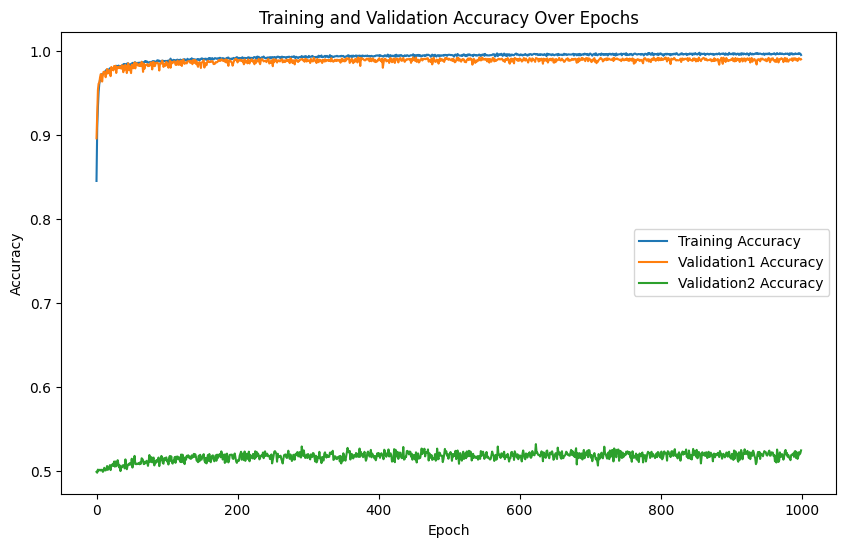

Accuracy: 0.9977333545684814


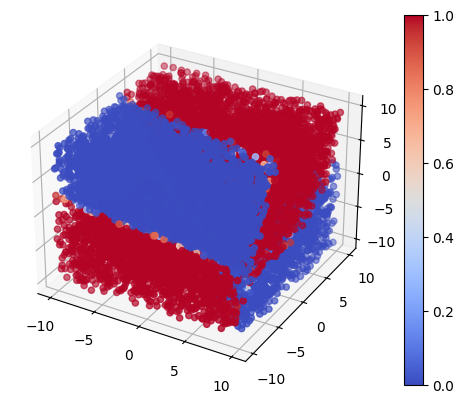

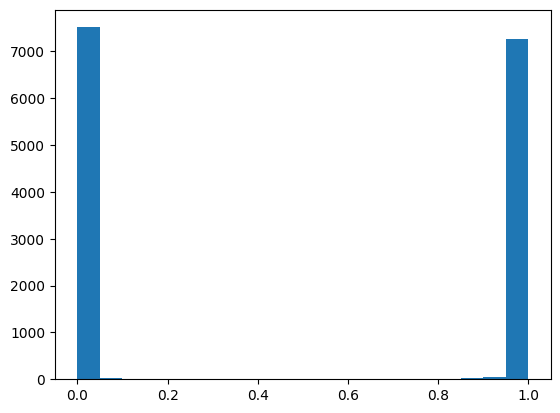

Accuracy: 0.9901333451271057


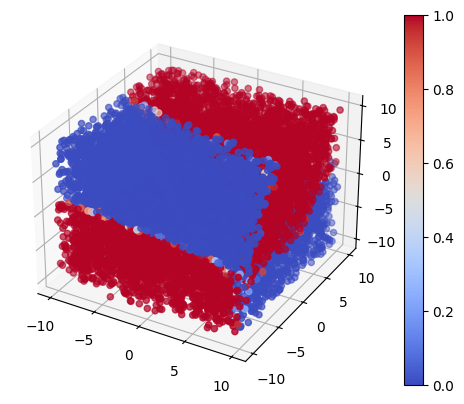

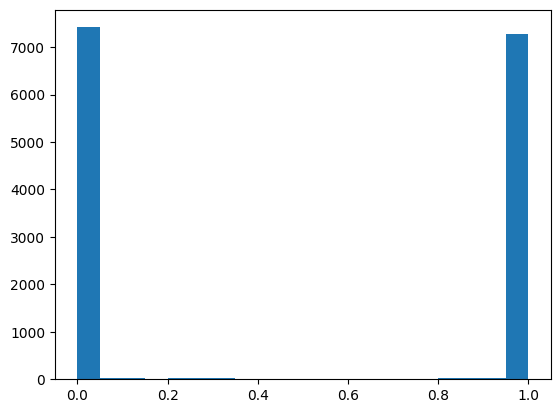

Accuracy: 0.5243333578109741


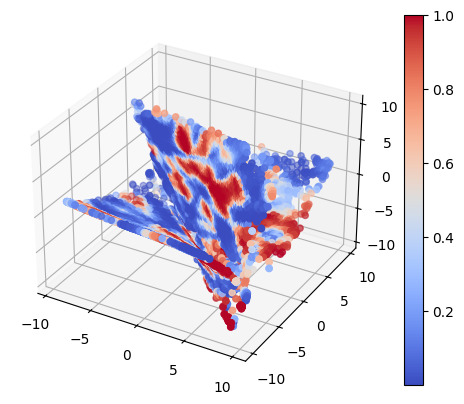

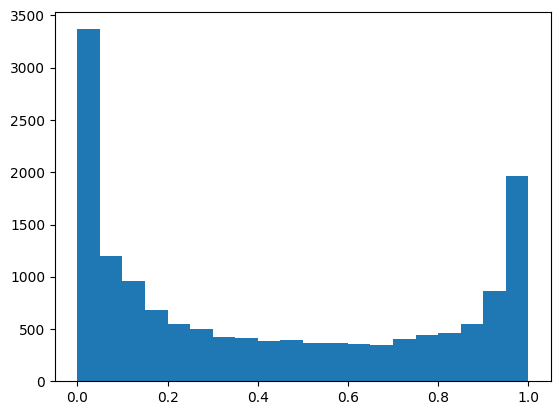

In [62]:
net_1 = Net()
train_model_bce(net_1, dataset_train, dataset_validation_uniform, dataset_validation_near, batchsize=32, epochs=1000, lr=0.0005)

Accuracy: 0.9901999831199646


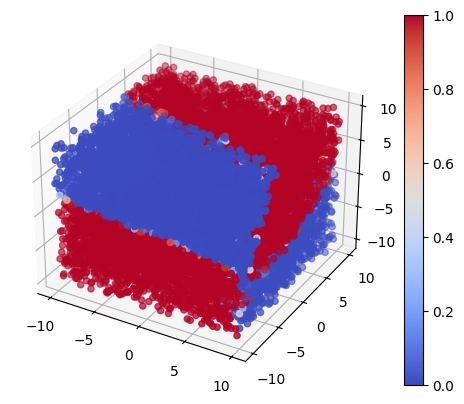

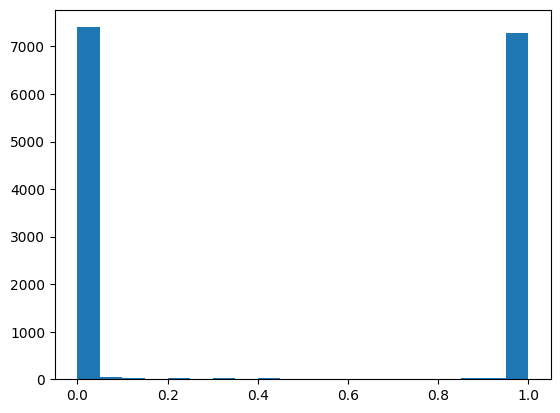

tensor(0.9902)

In [63]:
test_model(net_1, dataset_test_uniform)

Accuracy: 0.512333333492279


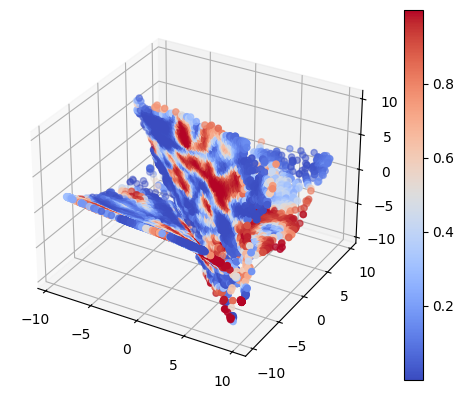

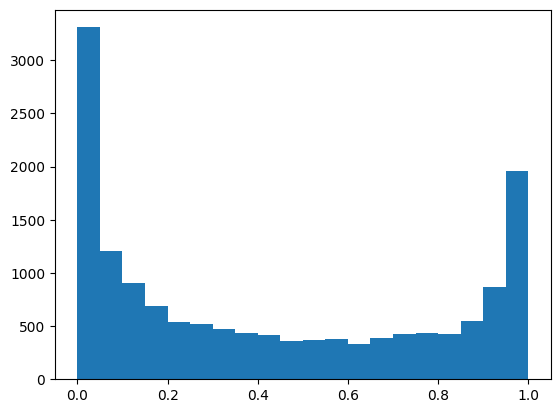

tensor(0.5123)

In [64]:
test_model(net_1, dataset_test_near)

In [65]:
## Data enhancement
#df_data = dataset_train.data

#df_data_1 = df_data[df_data['attracted'] == 1].sample(80, random_state=1)
#df_data_n1 = df_data[df_data['attracted'] == -1].sample(80, random_state=2)

#dataset_near = []
#for i in tqdm(range(len(df_data_1)), desc="Processing df_1"):
    #for j in range(len(df_data_n1)):
        #a = (df_data_1.iloc[i]['x0'], df_data_1.iloc[i]['y0'], df_data_1.iloc[i]['z0'])
        #b = (df_data_n1.iloc[j]['x0'], df_data_n1.iloc[j]['y0'], df_data_n1.iloc[j]['z0'])
        #a, b = bisection(a, b)
        #dataset_near.append([a[0], a[1], a[2], 1])
        #dataset_near.append([b[0], b[1], b[2], -1])

#df_near = pd.DataFrame(dataset_near, columns=['x0', 'y0', 'z0', 'attracted'])

#dataset_train.data = pd.concat([dataset_train.data, df_near], ignore_index=True)
#dataset_train.data.to_csv("dataset_lorenz_new_training_enhanced.csv", index=False)

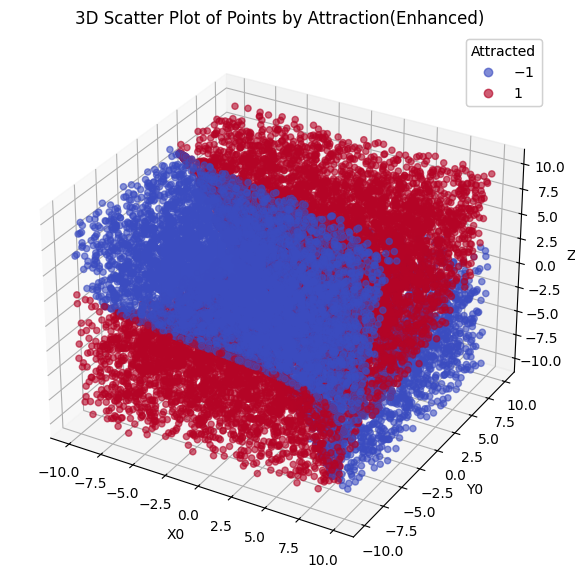

In [66]:
## Plot the enhanced training set
df = pd.read_csv('dataset_lorenz_new_training_enhanced.csv')

# Prepare the figure and 3D axis
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using x0, y0, z0 as coordinates
# Color by 'attracted': map the 'attracted' column to colors
scatter = ax.scatter(df['x0'], df['y0'], df['z0'], c=df['attracted'], cmap='coolwarm', alpha=0.6)

# Legend
legend1 = ax.legend(*scatter.legend_elements(), title="Attracted")
ax.add_artist(legend1)

# Labels
ax.set_xlabel('X0')
ax.set_ylabel('Y0')
ax.set_zlabel('Z0')
ax.set_title('3D Scatter Plot of Points by Attraction(Enhanced)')

# Show plot
plt.show()

Overall Training Progress: 100%|██████████| 1000/1000 [1:06:33<00:00,  3.99s/it, Training Accuracy=0.788, Validation1 Accuracy=0.993, Validation2 Accuracy=0.554]


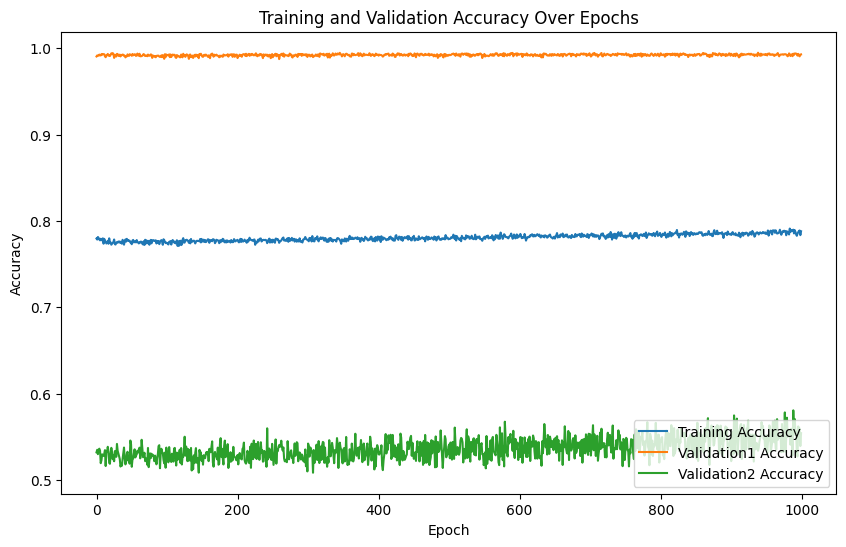

Accuracy: 0.7917625904083252


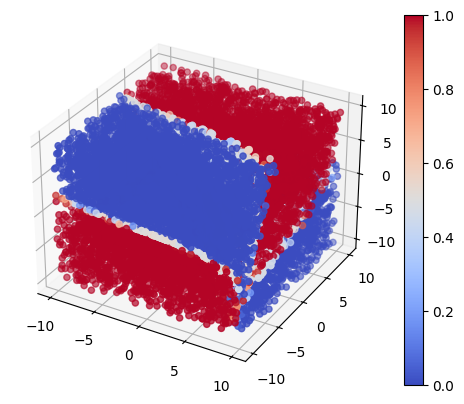

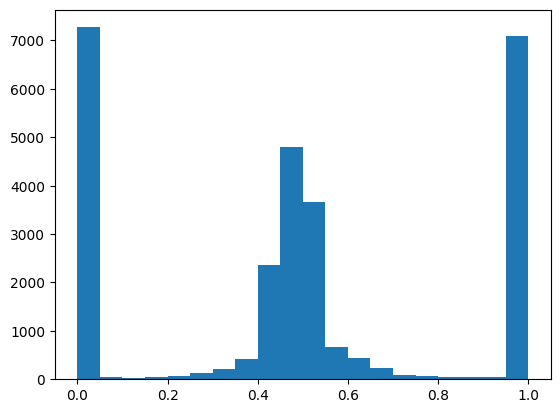

Accuracy: 0.992733359336853


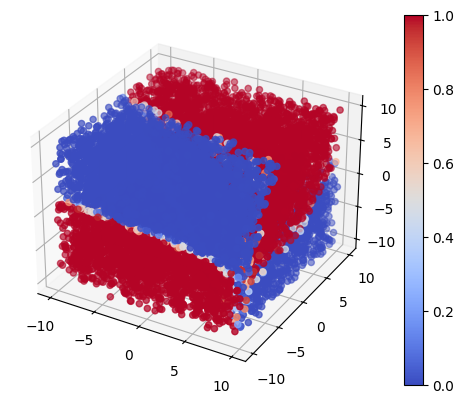

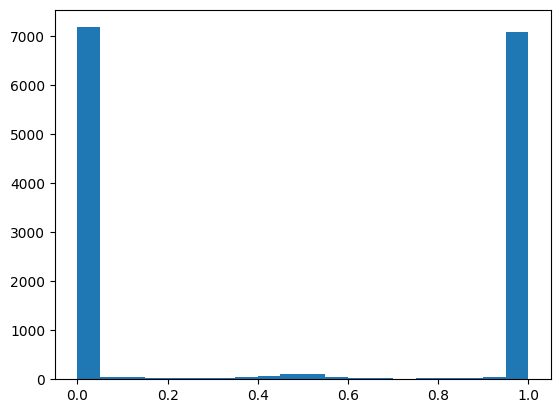

Accuracy: 0.5543333292007446


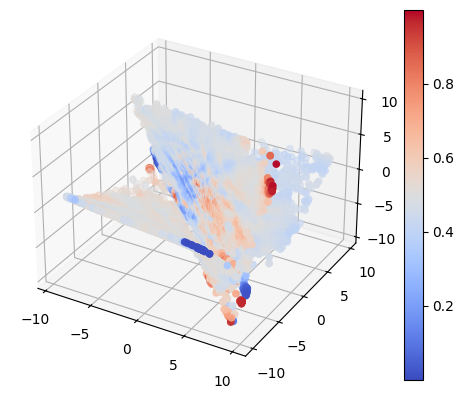

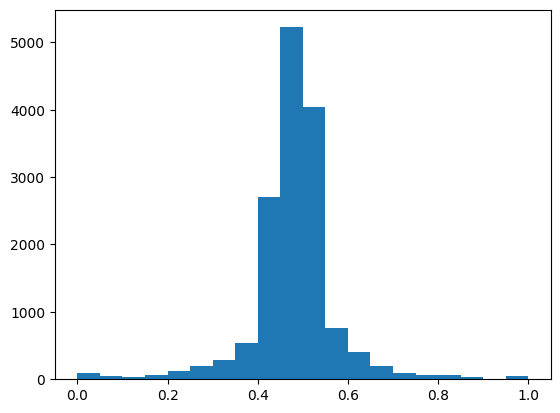

In [67]:
dataset_train_enhanced = LorenzDataset('dataset_lorenz_new_training_enhanced.csv')
net_2 = deepcopy(net_1)
train_model_bce(net_2, dataset_train_enhanced, dataset_validation_uniform, dataset_validation_near, batchsize=32, epochs=1000, lr=0.0005)

Accuracy: 0.9923999905586243


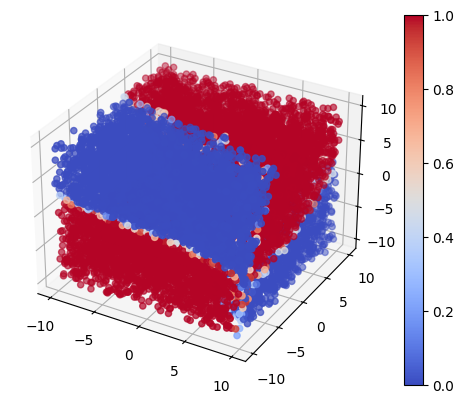

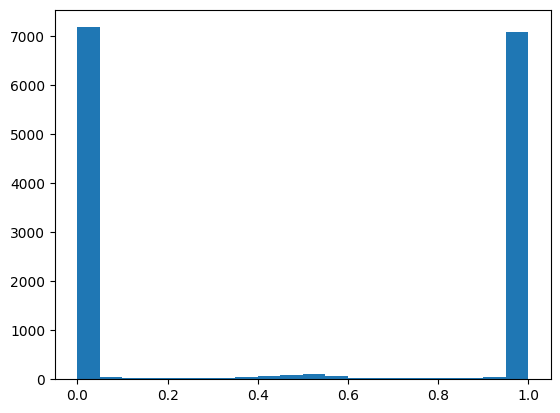

tensor(0.9924)

In [68]:
test_model(net_2, dataset_test_uniform)

Accuracy: 0.5507333278656006


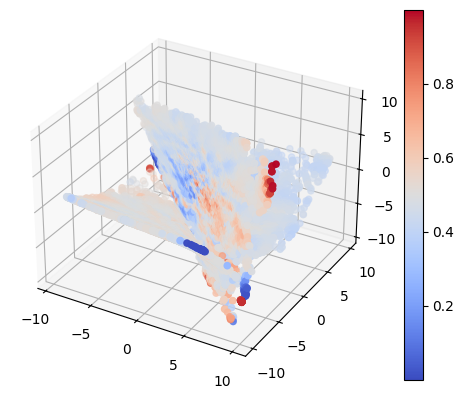

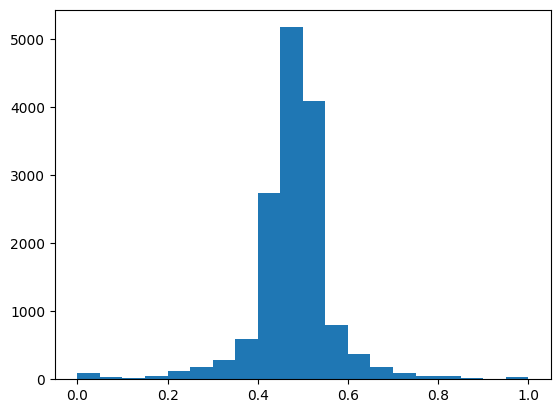

tensor(0.5507)

In [69]:
test_model(net_2, dataset_test_near)

In [70]:
## Weightage adaptation
class WeightedLorenzDataset(Dataset):
    def __init__(self, csv_file, weight=1.0):
        self.data = pd.read_csv(csv_file)
        # Initialize weight as a tensor of ones with the same length as the dataset
        self.weight = torch.full((len(self.data),), weight, dtype=torch.float32)
        # Normalize the weights
        self.weight /= self.weight.sum()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = torch.tensor([self.data.iloc[idx].x0, self.data.iloc[idx].y0, self.data.iloc[idx].z0]).float()
        label = torch.tensor(self.data.iloc[idx].attracted).float()
        weight = self.weight[idx]  # Get the weight for the current data point
        return features, label, weight
        
    
    def weight_reinitialization(self):
        # Reinitialize the weights as a tensor of ones with the same length as the dataset
        self.weight = torch.full((len(self.data),), 1.0, dtype=torch.float32)
        # Normalize the weights
        self.weight /= self.weight.sum()

In [71]:
def update_weights(net, dataset_train, sigma):
    net.eval()
    
    dataloader = DataLoader(dataset_train, batch_size=len(dataset_train), shuffle=False)
    
    for features, *_ in dataloader:
        with torch.no_grad():
            predicted_probs = net(features).view(-1)
    
    adjusted_probs = predicted_probs - 0.5
    
    # Compute the new weights using the Gaussian PDF formula. The variance is sigma^2, and mean (mu) is 0
    new_weights = (1 / (np.sqrt(2 * np.pi * sigma**2))) * torch.exp(-((adjusted_probs)**2) / (2 * sigma**2))
    new_weights /= new_weights.sum()
    
    return new_weights

In [72]:
def train_model_bce_with_weight_update(net, dataset_train, dataset_validation1, dataset_validation2, batchsize, epochs, lr):
    criterion = nn.BCELoss(reduction='none')
    optimizer = optim.Adam(net.parameters(), lr=lr)
    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    dataloader_validation1 = DataLoader(dataset_validation1, batch_size=batchsize, shuffle=False)
    dataloader_validation2 = DataLoader(dataset_validation2, batch_size=batchsize, shuffle=False)
    
    training_accuracy_over_epochs = []
    validation1_accuracy_over_epochs = []
    validation2_accuracy_over_epochs = []
    
    overall_progress = tqdm(total=epochs, desc='Overall Training Progress')
    
    for epoch in range(epochs):
        net.train()
        correct_predictions_train = 0
        total_predictions_train = 0
        for features, labels, weights in dataloader_train:
            labels = ((labels + 1) / 2).float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            loss = criterion(outputs, labels)
            weighted_loss = (loss * weights).sum()
            weighted_loss.backward()
            optimizer.step()
            correct_predictions_train += (outputs.round() == labels).float().sum().item()
            total_predictions_train += labels.size(0)
                    
        avg_training_accuracy = correct_predictions_train / total_predictions_train
        training_accuracy_over_epochs.append(avg_training_accuracy)
        
        net.eval()
        correct_predictions_validation1 = 0
        total_predictions_validation1 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation1:
                labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                correct_predictions_validation1 += (outputs.round() == labels).float().sum().item()
                total_predictions_validation1 += labels.size(0)
        
        avg_validation1_accuracy = correct_predictions_validation1 / total_predictions_validation1
        validation1_accuracy_over_epochs.append(avg_validation1_accuracy)

        correct_predictions_validation2 = 0
        total_predictions_validation2 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation2:
                labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                correct_predictions_validation2 += (outputs.round() == labels).float().sum().item()
                total_predictions_validation2 += labels.size(0)
        
        avg_validation2_accuracy = correct_predictions_validation2 / total_predictions_validation2
        validation2_accuracy_over_epochs.append(avg_validation2_accuracy)

        if (epoch + 1 ) % 250 == 0:
            time = (epoch + 1) // 250
            new_weights = update_weights(net, dataset_train, sigma=1-0.1*time)
            dataset_train.weight = new_weights
            dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
        
        overall_progress.update(1)
        overall_progress.set_postfix({'Training Accuracy': avg_training_accuracy, 'Validation1 Accuracy': avg_validation1_accuracy, 'Validation2 Accuracy': avg_validation2_accuracy})
        
    
    overall_progress.close()
    
    plt.figure(figsize=(10, 6))
    plt.plot(training_accuracy_over_epochs, label='Training Accuracy')
    plt.plot(validation1_accuracy_over_epochs, label='Validation1 Accuracy')
    plt.plot(validation2_accuracy_over_epochs, label='Validation2 Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()
    plt.show()
    
    test_model(net, dataset_validation1)
    test_model(net, dataset_validation2)

In [73]:
dataset_train_weighted = WeightedLorenzDataset('dataset_lorenz_new_training_enhanced.csv')

Overall Training Progress: 100%|██████████| 1000/1000 [1:07:52<00:00,  4.07s/it, Training Accuracy=0.797, Validation1 Accuracy=0.993, Validation2 Accuracy=0.58]


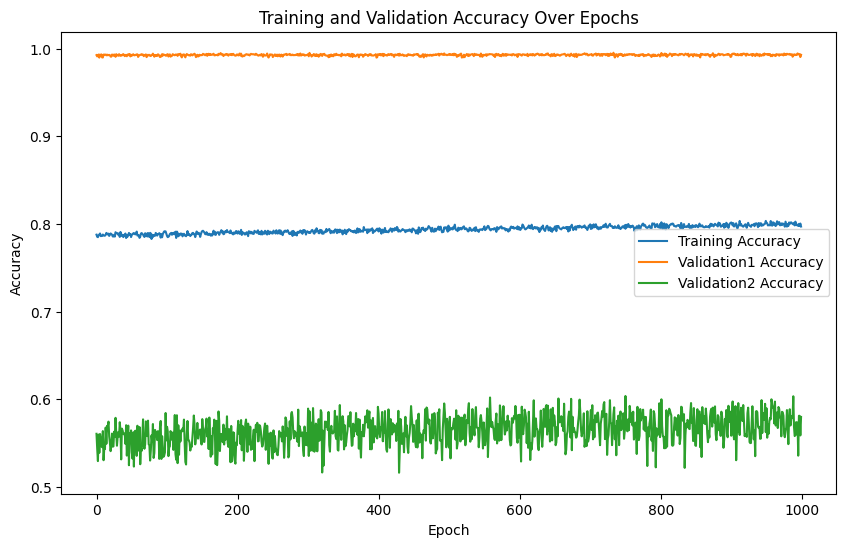

Accuracy: 0.9929333329200745


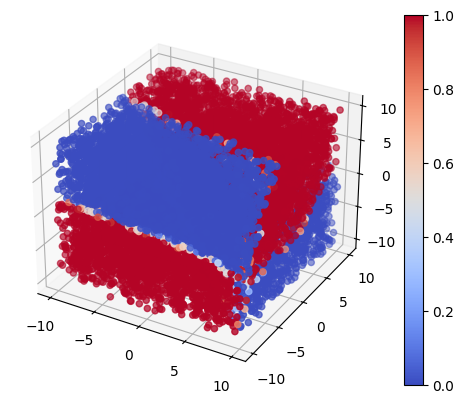

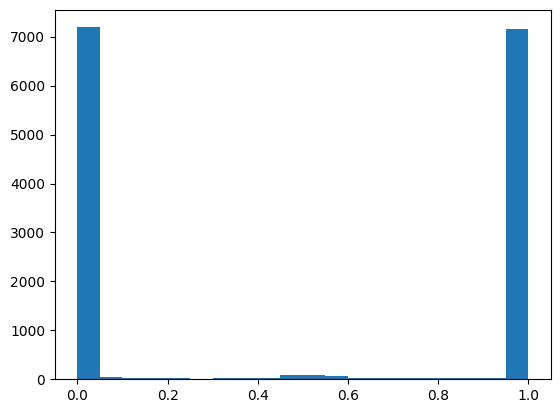

Accuracy: 0.5798666477203369


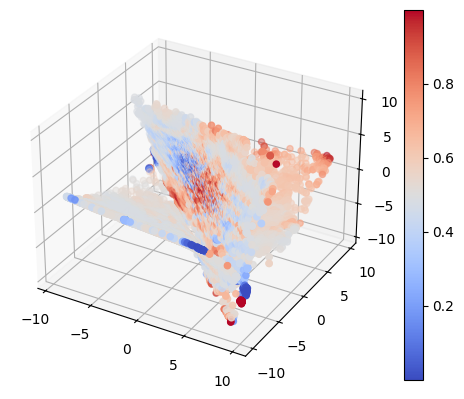

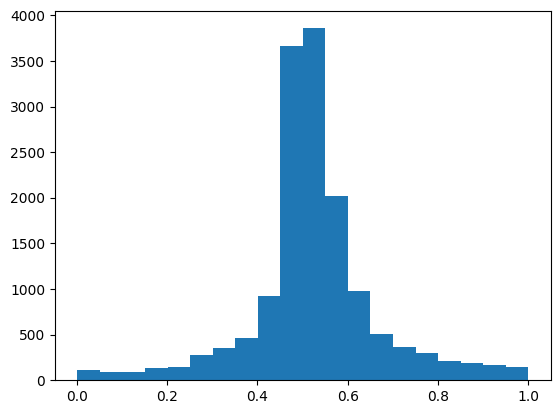

In [74]:
net_3 = deepcopy(net_2)
train_model_bce_with_weight_update(net_3, dataset_train_weighted, dataset_validation_uniform, dataset_validation_near, batchsize=32, epochs=1000, lr=0.0005)

Accuracy: 0.9928666949272156


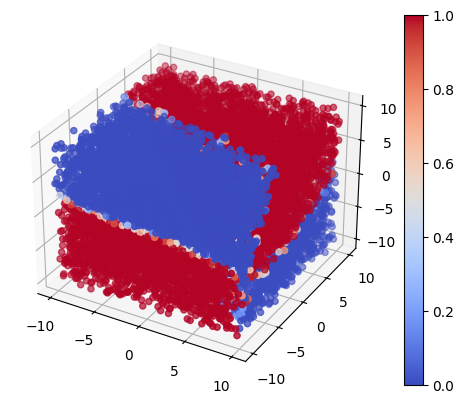

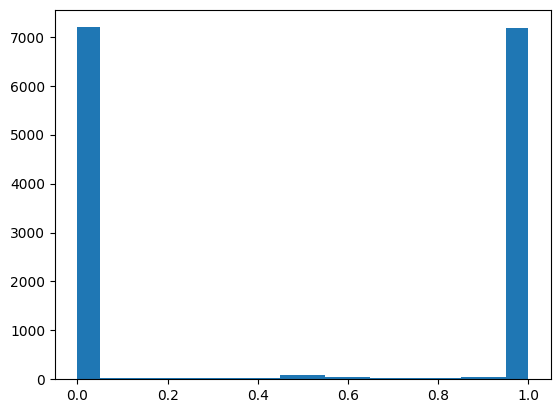

tensor(0.9929)

In [75]:
test_model(net_3, dataset_test_uniform)

Accuracy: 0.5803333520889282


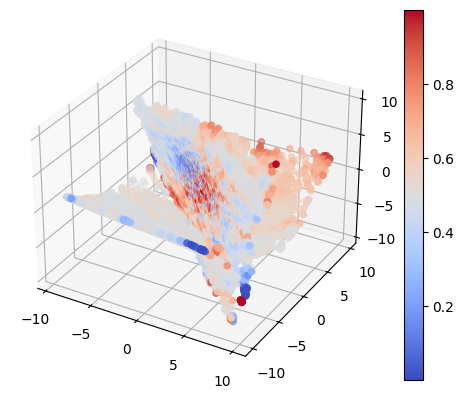

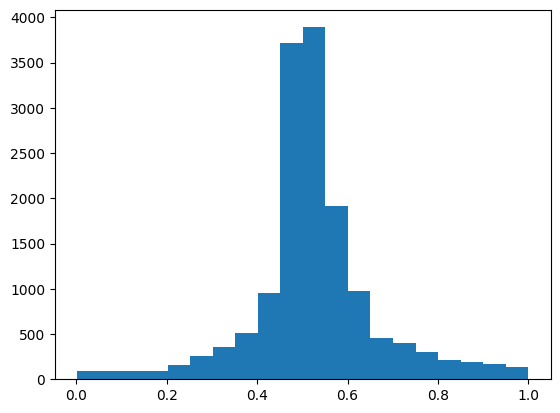

tensor(0.5803)

In [76]:
test_model(net_3, dataset_test_near)

In [34]:
## Dynamical Loss
# Assuming `f` is your trained neural network
# Example input point, requires_grad=True is crucial for gradient computation
f = net_3
input_point = torch.tensor([[-1, 0.5, 0.5]], dtype=torch.float32, requires_grad=True)

# Forward pass: compute the probability
probability = f(input_point)

# Check if the output is scalar (as required for backward)
if probability.nelement() == 1:
    # Backward pass: compute the gradient of the output with respect to the input
    probability.backward()

    # Extract the gradient vector
    gradient_vector = input_point.grad
    print("Gradient vector at the input point:", gradient_vector)

    # Normalize the gradient vector
    l2_norm = gradient_vector.norm(p=2)
    if l2_norm.item() > 0:
        normalized_gradient_vector = gradient_vector / l2_norm
        print("Normalized gradient vector:", normalized_gradient_vector)
    else:
        print("The gradient vector is zero and cannot be normalized.")
else:
    print("The output is not a scalar. Gradient computation requires scalar output.")

Gradient vector at the input point: tensor([[0., 0., 0.]])
The gradient vector is zero and cannot be normalized.


In [35]:
from torch.autograd import Variable

def find_decision_boundary_batch(f, initial_points, lr=0.001, threshold=1e-6, max_iter=1000):
    x = Variable(initial_points.clone(), requires_grad=True)
    optimizer = torch.optim.Adam([x], lr=lr)
    converged = torch.zeros(initial_points.size(0), dtype=torch.bool)
    
    for i in range(max_iter):
        optimizer.zero_grad()
        output = f(x)
        loss = (output - 0.5) ** 2
        loss = loss.mean(dim=1)  # Assuming f returns a tensor of shape (n_points,)
        loss.backward(torch.ones_like(loss))
        optimizer.step()
        
        # Check convergence for each point
        converged |= (loss < threshold)
        if converged.all():
            print(f"All converged after {i+1} iterations.")
            break
    
    return x, converged

def collect_converged_points(f, target_count=1000):
    collected_points = []
    while len(collected_points) < target_count:
        n_points_needed = 10000
        initial_points = (torch.rand(n_points_needed, 3) * 20) - 10  # Generate more points
        x_star_batch, converged = find_decision_boundary_batch(f, initial_points)
        converged_points = x_star_batch[converged]
        collected_points.extend(converged_points.detach().numpy().tolist())  # Convert to list and append
        
    return torch.tensor(collected_points[:target_count])  # Return the first 1,000 converged points

# Example usage
collected_points = collect_converged_points(net_3)
print(f"Collected {len(collected_points)} converged points.")
outputs = net_3(collected_points)
# Assuming collected_points and outputs are already defined as shown above
for point, output in zip(collected_points, outputs):
    print(f"Point: {point}, Output: {output.item()}")


Collected 1000 converged points.
Point: tensor([ 8.8680,  3.6843, -2.5650]), Output: 0.5000016689300537
Point: tensor([-3.4137,  4.9783, -4.6982]), Output: 0.5043958425521851
Point: tensor([-1.8255,  6.7156, -2.2181]), Output: 0.5043958425521851
Point: tensor([ 3.3805,  3.6396, -3.4226]), Output: 0.5043958425521851
Point: tensor([8.0055, 8.7634, 0.8675]), Output: 0.5043958425521851
Point: tensor([-2.0060,  8.1186, -0.7710]), Output: 0.4999995231628418
Point: tensor([-0.8309,  5.8735, -2.7777]), Output: 0.4999988079071045
Point: tensor([ 5.7865,  5.8425, -1.8058]), Output: 0.5043958425521851
Point: tensor([ 4.9071,  2.6673, -3.5405]), Output: 0.5043958425521851
Point: tensor([ 6.7936,  6.7842, -1.0508]), Output: 0.5000021457672119
Point: tensor([ 8.5314,  2.4878, -3.1708]), Output: 0.5043958425521851
Point: tensor([ 2.3664, -1.2960,  3.6852]), Output: 0.5043958425521851
Point: tensor([-5.0178,  6.6884, -3.4287]), Output: 0.49999964237213135
Point: tensor([ 0.7617, -0.7427, -3.8400]), Ou

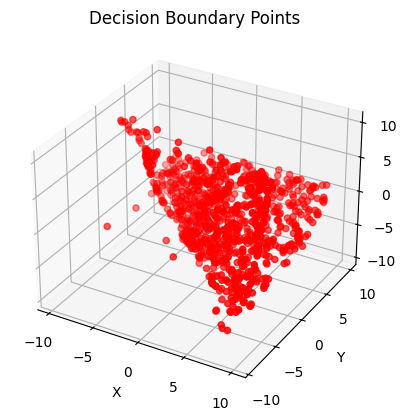

In [36]:
# Assuming collected_points is a tensor of shape (n_points, 2) where n_points >= 1000
x_coords = collected_points[:, 0].numpy()  # Extract x-coordinates
y_coords = collected_points[:, 1].numpy()  # Extract y-coordinates
z_coords = collected_points[:, 2].numpy()  # Extract z-coordinates

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_coords, y_coords, z_coords, c='r', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Decision Boundary Points')
plt.show()

In [37]:
# Convert to a PyTorch tensor if needed
input_matrix = torch.tensor(collected_points, dtype=torch.float32, requires_grad=True)

print(input_matrix)

tensor([[ 8.8680,  3.6843, -2.5650],
        [-3.4137,  4.9783, -4.6982],
        [-1.8255,  6.7156, -2.2181],
        ...,
        [ 6.9536, -2.6236, -4.4949],
        [-1.9946,  3.2571, -5.7823],
        [-7.7780,  1.0739, 10.0682]], requires_grad=True)


In [38]:
# Placeholder for gradient vectors
gradient_vectors = []

for i in range(len(input_matrix)):
    # Zero the gradients to ensure correct gradient calculation
    if input_matrix.grad is not None:
        input_matrix.grad.zero_()
    
    # Forward pass for the i-th point
    probability = net_3(input_matrix[i].unsqueeze(0))
    
    # Compute the gradient for the i-th point
    probability.backward()

    # Extract and store the gradient vector for the i-th point
    gradient_vectors.append(input_matrix.grad[i].clone())

# Optionally, normalize each gradient vector
normalized_gradient_vectors = [g / g.norm(p=2) if g.norm(p=2) > 0 else g for g in gradient_vectors]

print("Gradient vectors for each point:", gradient_vectors)
print("Normalized gradient vectors for each point:", normalized_gradient_vectors)
df_grad = pd.DataFrame(normalized_gradient_vectors, columns=['x', 'y', 'z'])


Gradient vectors for each point: [tensor([-0.3569, -1.4603,  3.0286]), tensor([0., 0., 0.]), tensor([0., 0., 0.]), tensor([0., 0., 0.]), tensor([0., 0., 0.]), tensor([-0.1762, -1.9555,  2.4790]), tensor([-0.4960, -1.5046,  1.9444]), tensor([0., 0., 0.]), tensor([0., 0., 0.]), tensor([-0.4000, -2.1047,  2.8216]), tensor([0., 0., 0.]), tensor([0., 0., 0.]), tensor([-1.2362, -2.8175,  1.3160]), tensor([0., 0., 0.]), tensor([0., 0., 0.]), tensor([0., 0., 0.]), tensor([0., 0., 0.]), tensor([0.7212, 0.6633, 0.5071]), tensor([0., 0., 0.]), tensor([0., 0., 0.]), tensor([0., 0., 0.]), tensor([ 0.4600,  1.6864, -1.0227]), tensor([0., 0., 0.]), tensor([ 0.4273,  0.5605, -0.1032]), tensor([0., 0., 0.]), tensor([-0.1954, -2.3027,  2.1799]), tensor([ 0.3515,  1.7067, -0.9001]), tensor([ 0.3823,  1.7481, -0.9124]), tensor([0., 0., 0.]), tensor([0.8125, 0.9570, 0.1943]), tensor([0., 0., 0.]), tensor([0.8125, 0.9570, 0.1943]), tensor([0., 0., 0.]), tensor([14.3671, 25.2355, -8.0341]), tensor([0., 0., 0

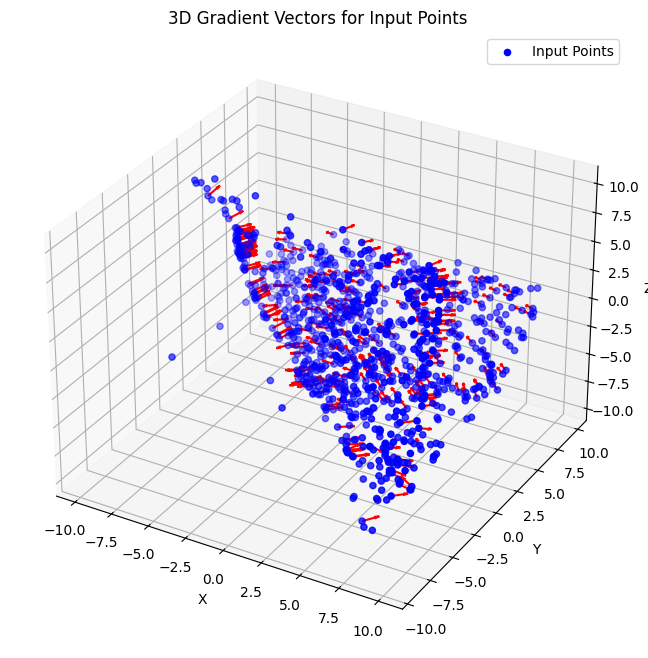

In [39]:
# Assuming 'input_matrix' is your input matrix and 'gradient_vectors' contains the computed gradients
# Convert input_matrix and gradient_vectors to numpy arrays for easier manipulation
points = input_matrix.detach().numpy()  # Detach and convert to numpy for plotting
gradients = np.array([g.detach().numpy() for g in normalized_gradient_vectors])  # Convert gradients to numpy

# Extract x and y coordinates of points
x_coords, y_coords, z_coords = points[:, 0], points[:, 1], points[:, 2]

# Extract x and y components of gradients
grad_x, grad_y, grad_z = gradients[:, 0], gradients[:, 1], gradients[:, 2]

# Plotting in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

# 3D vector field
ax.quiver(x_coords, y_coords, z_coords, grad_x, grad_y, grad_z, color='r')

# 3D scatter plot for points
ax.scatter(x_coords, y_coords, z_coords, color='b', label='Input Points')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Gradient Vectors for Input Points')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
def integrand(inputs, net, system):
    gradient_vectors = []
    system_vectors = []
    probability_values = []
    for input_point in inputs:
        input_point = torch.tensor(input_point, dtype=torch.float32, requires_grad=True)
        probability = net(input_point.unsqueeze(0))
        probability.backward()
        probability_values.append(probability.detach().numpy())
        gradient_vector = input_point.grad
        gradient_vectors.append(gradient_vector.detach().numpy())
        system_vector = system(0, input_point.detach().numpy())
        system_vectors.append(system_vector)
    normalized_gradient_vectors = [g / np.linalg.norm(g) if np.linalg.norm(g) > 0 else g for g in gradient_vectors]
    normalized_system_vectors = [s / np.linalg.norm(s) if np.linalg.norm(s) > 0 else s for s in system_vectors]
    dot_products = [(np.dot(g, s) ** 2) for g, s in zip(normalized_gradient_vectors, normalized_system_vectors)]
    gradient_norm = [np.linalg.norm(g) for g in gradient_vectors]
    dot_products = np.array(dot_products)
    gradient_norm = np.array(gradient_norm)
    probability_values = np.array(probability_values)
    result = dot_products * gradient_norm
    def dirac(probability, var = 0.0001):
        return np.exp(-(probability-0.5)**2 / (2 * var**2)) / np.sqrt(2 * np.pi * var**2)
    return result * dirac(probability_values)

In [41]:
def integrate_function_over_region_batched(func, net, system, x_limits=(-10, 10), y_limits=(-10, 10), z_limits=(-10, 10), N=500, batch_size=1000):
    x_start, x_end = x_limits
    y_start, y_end = y_limits
    z_start, z_end = z_limits
    dx = (x_end - x_start) / N
    dy = (y_end - y_start) / N
    dz = (z_end - z_start) / N
    
    total_points = (N + 1) ** 3  # Updated for 3D
    num_batches = int(np.ceil(total_points / batch_size))
    
    integral = 0
    
    for batch in range(num_batches):
        start_idx = batch * batch_size
        end_idx = min(start_idx + batch_size, total_points)
        
        batch_indices = np.unravel_index(np.arange(start_idx, end_idx), (N + 1, N + 1, N + 1))  # Updated for 3D
        x_batch = np.linspace(x_start, x_end, N + 1)[batch_indices[2]]
        y_batch = np.linspace(y_start, y_end, N + 1)[batch_indices[1]]
        z_batch = np.linspace(z_start, z_end, N + 1)[batch_indices[0]]
        inputs = np.vstack([x_batch, y_batch, z_batch]).T  # Updated for 3D
        
        Z_batch = func(inputs, net, system).reshape(-1)
        
        weights_batch = np.ones_like(Z_batch)
        
        # Edge case adjustments need to be updated for 3D, this is a simplified version
        # For a full implementation, consider all edges and corners in 3D
        if batch == 0:
            weights_batch[:N+1] *= 0.5
        if batch == num_batches - 1:
            weights_batch[-(N+1):] *= 0.5
        
        integral += np.sum(Z_batch * weights_batch * dx * dy * dz)  # Updated for 3D
    
    return integral

# Integrate using the batch processing function
integral_value = integrate_function_over_region_batched(integrand, net_3, lorenz)
print(f"Integral value: {integral_value}")

Integral value: 377.8539078877808


In [42]:
def train_model_dynamical(net, dataset_train, dataset_validation1, dataset_validation2, batchsize, epochs, lr, magnitude):
    criterion = nn.BCELoss(reduction='none')
    optimizer = optim.Adam(net.parameters(), lr=lr)
    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    dataloader_validation1 = DataLoader(dataset_validation1, batch_size=batchsize, shuffle=False)
    dataloader_validation2 = DataLoader(dataset_validation2, batch_size=batchsize, shuffle=False)
    
    training_accuracy_over_epochs = []
    validation1_accuracy_over_epochs = []
    validation2_accuracy_over_epochs = []
    
    overall_progress = tqdm(total=epochs, desc='Overall Training Progress')
    
    for epoch in range(epochs):
        net.train()
        correct_predictions_train = 0
        total_predictions_train = 0
        for features, labels, weights in dataloader_train:
            labels = ((labels + 1) / 2).float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            loss = criterion(outputs, labels)
            weighted_loss = (loss * weights).sum()
            weighted_loss = weighted_loss + integrate_function_over_region_batched(integrand, net, lorenz) * magnitude
            #weighted_loss = integrate_function_over_region_batched(integrand, net, system) * magnitude
            weighted_loss = torch.tensor(weighted_loss, requires_grad=True)
            weighted_loss.backward()
            optimizer.step()
            correct_predictions_train += (outputs.round() == labels).float().sum().item()
            total_predictions_train += labels.size(0)
                    
        avg_training_accuracy = correct_predictions_train / total_predictions_train
        training_accuracy_over_epochs.append(avg_training_accuracy)
        
        net.eval()
        correct_predictions_validation1 = 0
        total_predictions_validation1 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation1:
                labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                correct_predictions_validation1 += (outputs.round() == labels).float().sum().item()
                total_predictions_validation1 += labels.size(0)
        
        avg_validation1_accuracy = correct_predictions_validation1 / total_predictions_validation1
        validation1_accuracy_over_epochs.append(avg_validation1_accuracy)

        correct_predictions_validation2 = 0
        total_predictions_validation2 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation2:
                labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                correct_predictions_validation2 += (outputs.round() == labels).float().sum().item()
                total_predictions_validation2 += labels.size(0)
        
        avg_validation2_accuracy = correct_predictions_validation2 / total_predictions_validation2
        validation2_accuracy_over_epochs.append(avg_validation2_accuracy)

        #if (epoch + 1 ) % 1000 == 0:
            #time = (epoch + 1) // 1000
            #new_weights = update_weights(net, dataset_train, sigma=1-0.1*time)
            #dataset_train.weight = new_weights
            #dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
        
        overall_progress.update(1)
        overall_progress.set_postfix({'Training Accuracy': avg_training_accuracy, 'Validation1 Accuracy': avg_validation1_accuracy, 'Validation2 Accuracy': avg_validation2_accuracy})
        
    
    overall_progress.close()
    
    plt.figure(figsize=(10, 6))
    plt.plot(training_accuracy_over_epochs, label='Training Accuracy')
    plt.plot(validation1_accuracy_over_epochs, label='Validation1 Accuracy')
    plt.plot(validation2_accuracy_over_epochs, label='Validation2 Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()
    plt.show()
    
    test_model(net, dataset_validation1)
    test_model(net, dataset_validation2)

In [43]:
net_4 = deepcopy(net_3)
train_model_dynamical(net_4, dataset_train_weighted, dataset_validation_uniform, dataset_validation_near, batchsize=len(dataset_train_weighted), epochs=20, lr=0.00001, magnitude=0.00001)

Overall Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 